In [173]:
from qiskit import *
from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
from math import pi
import matplotlib.pyplot as plt
import re
import csv
import time
start = time.time()

### Target state $|w>$

In [174]:
Target_state = '000000'

## Setting up the The Grover operator
$$ G = U_w U_s$$
Where 
$$U_w = 2|w><w| - I$$ 
$U_w$ is a matrix with the position of the target state 1 and all its diagnoal elements are -1 and rest all zero.

In [175]:
# First we note the length of N.
N = len(Target_state)

# Then an identity matrix is created with the size 2**N with signs reversed.
U_w = - np.identity(2 ** N, dtype=complex)


# Then the sign of the element corresponding to the target state is flipped. To do that we first convert the
# target state from binary to decimal number. 
Target_index = int(Target_state, 2)

## The position of the target state is set as 1.
U_w.itemset((Target_index, Target_index),1)

$$ U_s = 2|s><s| - I $$
Where $$ |s> = \frac{1}{\sqrt{2^N}} \sum_{x} |x>$$
$2|s><s|$ is a matrix with all its elements $\frac{2}{2^N}$. 

In [176]:
## We will first create a matrix with all elements 1. This is |psi><psi| = A(say).
A = np.ones((2**N, 2**N))

## U_s = 2\(2**N)2|psi><psi| - I
U_s = (2/(2**N))*A - np.identity(2**N)

## G is the Grover operator.
G = np.matmul(U_w, U_s)


print('The Grover operator for the target state |w > = | '+Target_state + ' > is \n\n',G.real)

The Grover operator for the target state |w > = | 000000 > is 

 [[-0.96875  0.03125  0.03125 ...  0.03125  0.03125  0.03125]
 [-0.03125  0.96875 -0.03125 ... -0.03125 -0.03125 -0.03125]
 [-0.03125 -0.03125  0.96875 ... -0.03125 -0.03125 -0.03125]
 ...
 [-0.03125 -0.03125 -0.03125 ...  0.96875 -0.03125 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125  0.96875 -0.03125]
 [-0.03125 -0.03125 -0.03125 ... -0.03125 -0.03125  0.96875]]


## Setting up the circuit

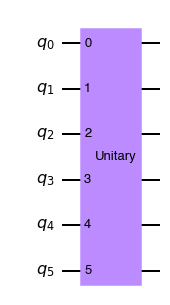

In [177]:
qc = QuantumCircuit(N)
qc.unitary(U_w,[i for i in range(N)])
qc.draw('mpl')

## For transpile, we will choose the basis gates as $Rz, CNOT$ and $H$

In [178]:
trans_qc = transpile(qc, basis_gates = ['id', 'rz', 'cx','h'], optimization_level = 2)
#trans_qc.draw('mpl')

### Writing $1$ and $2$ qubit gates as human readable format.
The following loop puts the gates in a text file.

In [179]:
## The transpile comnand returns transpiled gates in the following structure. For example,
# a Rz gate acting on qubit 0 with angle 0.98 looks like the following.
## (Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.9817477042468101]),
#[Qubit(QuantumRegister(3, 'q'), 0)], [])


# a Hadamard gate acting on qubit 0 looks like the following.
## (Instruction(name='h', num_qubits=1, num_clbits=0, params=[]), [Qubit(QuantumRegister(3, 'q'), 0)], [])

# a CNOT gate looks like the following.
## (Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]),
#[Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 0)], [])


f = trans_qc
def List_Gates(Gate_Number):
    
    
    ## The list will hold string along with the angles.
    l = []
    
    Name_of_Gate = []
    
    ## The list will hold the qubit that the gate is acting on.
    Qubit = []    
    
    ## The list will hold the numerical value (float) of the angle for Rz.
    Angle = []

    ## The following two lines will be used to separate the numerical value of the angle from 
    # a mixture of string and digits.
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ )?'
    
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    
    if str(trans_qc[Gate_Number][0]).split(',')[0][-3:-1] == 'rz':
        
        Name_of_Gate.append('rz')        
        ## For the gate rz, there is one angle. The following lines puts the string which contain
        # the angle along with other alphabets in a list l.
        l.append(str(list(f)[Gate_Number]).split(',')[3])

        
        ## The following loop extracts the angle from the string of alphabet and digit.
        for i in l:
            
            if rx.findall(i) == []:
                
                ## the angle zero is written as 0.0 .
                Angle.append(0.0)
                
            else:
                
                Angle.append(float(rx.findall(i)[0]))
                
        ## the qubit on which rz acts is listed.        
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))  
        
    # For hadamard gates the qubit it is applied to is listed.    
    elif str(trans_qc[Gate_Number][0]).split(',')[0][-2:-1] == 'h':
        
        Name_of_Gate.append('h')
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))
    
    
        ## if the gate is cx then the Angle list is empty.        
    else:
        
        Name_of_Gate.append('cx')     
        ## the control and the target bit is listed.
        Control_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][0]).split(',')[2])
        
        Target_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][1]).split(',')[2])   
        
        Qubit.append([Control_bit, Target_bit])
    
    
    return Name_of_Gate,Angle, Qubit



# The following list has all the gates in the format [name of the gate, angle, qubit].
l = []
for i in range(len(f)):
    l.append(List_Gates(i))      

## To view the gates, open the following text file.    
file = open('gates_list'+Target_state+'.txt', 'w')


# The following variables will count number of each gates.
rz_count = 0
h_count = 0
cx_count = 0


## The following loop writes the gates into the file.
for i in range(len(l)):
    
    if l[i][0][0] == 'rz':
        
        file.write('rz'+','+str(l[i][1][0])+','+str(l[i][2][0])+','+'\n')
        
        rz_count += 1
        
    elif l[i][0][0] == 'h':
        
        file.write('h'+','+'0.0'+','+str(l[i][2][0])+','+'\n')
        
        h_count += 1
        
    else:
        
        file.write('cx'+','+l[i][2][0][0]+','+l[i][2][0][1]+','+'\n')
        
        cx_count += 1

print(
    'Total gates used = ',len(l),'\n' \
      'Number of Rz gates =', rz_count,'\n'\
      'Number of Hadamard gates =', h_count,'\n'\
      'Number of CNOT gates =', cx_count
        )   
Rz_Number = rz_count

Total gates used =  5950 
Number of Rz gates = 2135 
Number of Hadamard gates = 2508 
Number of CNOT gates = 1307


## The basis gates
The following returns the matrix of the Hadamard, CNOT and RZ gate.

### Hadamard gate

In [180]:
## The dimension of the matrix is fixed by the number of qubits.
def Hadamard(Qubit):
    
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.h(Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)

### CNOT gate

In [181]:
## The dimension of the matrix is fixed by the number of qubits.
def CNOT(t,c):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.cx(t,c)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ) 

### RZ gate

In [182]:
def Rz(Angle, Qubit):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.rz(Angle, Qubit)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return result.get_unitary(circ)     

## Reconstruction of the Oracle matrix from the transpile
The following multiplys the one and two qubits to get the Oracle $U_w$. This part is not required for the overall functioning of the code.

In [183]:
def Uw_NoNoise():
    
    ## Initializing the oracle U_w as an identity matrix.
    
    Or = np.identity(2**N) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with (or without) noise.
    
    
    for i in range(len(l)): # l is the list with all the gates.
    
        if l[i][0][0] == 'rz':
            
            Or = np.matmul(Or, Rz(float(l[i][1][0]), int(l[i][2][0])))
        
        elif l[i][0][0] == 'h':
        
            Or = np.matmul(Or, Hadamard(int(l[i][2][0])))
        
        else:
        
            Or = np.matmul(Or, CNOT(int(l[i][2][0][0]), int(l[i][2][0][1])))
     
    Or = Or/Or[0,0]
    
    if np.sign(Or[0,0]) == np.sign(U_w[0,0]):
        
        pass
    
    else:
        
        Or = -Or

    return Or

### Comparison of the Oracle $U_w$ before and after the transpile

In [184]:
#print('Oiginal Oracle \n\n', U_w.real, '\n\n Oracle from transpile \n\n', np.around(Uw_NoNoise(),4).real)

## Adding noise to the Oracle

### Noise creation
This following line creates an array of random numbers which length is equal to the number of Rz gates.
$$\delta = [\delta_1, \delta_2, ..., \delta_{\text{Number of Rz}}]$$
Where $\delta_i$ are random numbers between $-1$ and $1$.  

In [185]:
#Rz_Noise = 2*(np.random.rand(Rz_Number)-0.5)

# Use the line below for no noise case.
#Rz_Noise = np.zeros(Rz_Number)

In the following $\epsilon$ acts as a strength of noise. The array Rz_Noise has random numbers from -1 to 1. The following function multiplies $\epsilon$ to each random numbers in Rz_Noise and add that to each Rz gate of the oracle $U_w$. We will first reconstruct the Grover operator by first constructing the oracle $U_w$ from the transpile and then by multiplying $U_w$ and $U_s$ to get $G$.

In [186]:
def Grover_reconstructed(epsilon):
    
    # for entropy creating different noise.
    Rz_Noise = 2*(np.random.rand(Rz_Number)-0.5)
    
    
    ## Initializing the oracle U_w as an identity matrix.
    
    Or = np.identity(2**N) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with (or without) noise.
    
    j = 0 # Index for the random noise list.
    
    for i in range(len(l)): # l is the list with all the gates.
    
        if l[i][0][0] == 'rz':
            
            Or = np.matmul(Or, Rz(float(l[i][1][0])  + epsilon * Rz_Noise[j], int(l[i][2][0])))
            
            j = j + 1
        
        elif l[i][0][0] == 'h':
        
            Or = np.matmul(Or, Hadamard(int(l[i][2][0])))
        
        else:
        
            Or = np.matmul(Or, CNOT(int(l[i][2][0][0]), int(l[i][2][0][1])))
     
    ## In the following we will fix the phase of the reconstructed Oracle. First we will make all the elements
    # 1 or -1.
    Or = Or/Or[0,0]
    
    ## The sign of the reconstructed Oracle should be same as that of original U_w.
    if np.sign(Or[0,0]) == np.sign(U_w[0,0]):
        
        pass # If the sign is same, then pass.
    
    else:
        
        Or = -Or # Otherwise change the sign.
    Gr = np.matmul(Or, U_s) ## The Grover operator G = U_w * U_s.
    
    return Gr

### Comparison of the Grover operator $G$ before and after and the transpile

In [187]:
#print('Original Grover operator\n\n', G.real,'\n\n Grover after transpile \n\n', 
      #np.around(Grover_reconstructed(0).real,4))

## Diagnonalization of G
The following code puts G in the form $G = V e^{-i \phi_F} V^{\dagger}$, where $V$ is unitary and $\phi_F$ is a diagonal matrix.

In [188]:
import numpy
import numpy.linalg

sigma_x=numpy.zeros((2,2),dtype=complex)
sigma_y=numpy.zeros((2,2),dtype=complex)
sigma_z=numpy.zeros((2,2),dtype=complex)
sigma_0=numpy.identity(2,dtype=complex)
sigma_x[0,1]=1.
sigma_x[1,0]=1.
sigma_y[0,1]=-1.j
sigma_y[1,0]=1.j
sigma_z[0,0]=1.
sigma_z[1,1]=-1.
sigma_plus=(sigma_x+1.j*sigma_y)/2.
sigma_minus=(sigma_x-1.j*sigma_y)/2.

def adjoint(psi):
    return psi.conjugate().transpose()

def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())

def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))

def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))

def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns

def comm(a,b):
    return a.dot(b)-b.dot(a)

def anti_comm(a,b):
    return a.dot(b)+b.dot(a)

def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol

def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol

def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)

    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))

    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger



### Checking that $V$ is unitary

In [189]:
#V = eigu(G)[1]

# Hermitian conjugate of V.
#V_d = (np.conjugate(V)).transpose()

In [190]:
#print('V * V^\dagger = \n\n', np.around(np.matmul(V, V_d),4))

### $\phi_F$ from $U_d$
Given $U_d$ by the function eigu, this function returns an array $\phi_F$.
$$V e^{-i \phi_F} V^{\dagger} = V U_d V^{\dagger}$$ so, $$e^{-i \phi_F} = U_d$$ or $$ \phi_F = i \log(U_d) $$
The following function returns and array vector $\phi_F$ for an operator as input.


In [191]:
def Phi_F(operator): 
    
    return (1j*np.log(eigu(operator)[0])).real  # eigu(Gr)[0] = exp(-i * phi_F).

### $\phi_F$ of the constructed Grover operator without noise

In [192]:
np.around(Phi_F(Grover_reconstructed(0)),8)

array([ 2.89093699,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -2.89093699])

### $\phi_F$ of the original Grover operator

In [193]:
Phi_F(G)

array([ 2.89093699,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        , -0.        , -2.89093699])

## Ploting the graph

In [194]:
L = N // 2 # Length of half cut number of qubits.

In [195]:


'''
    The following function takes a wavefunction as input and returns its entropy.

'''

def Entropy(Wavefunction):




    # Converting the list to a numpy matrix.
    Psi = np.matrix(Wavefunction).reshape(len(Wavefunction),1) # Psi column matrix.

    # Normalizing Psi.
    Psi = Psi/np.linalg.norm(Psi)


      
    
    def psi(s):
        return Psi[(2**L)*s:(2**L)*s + 2**L]   
    
      
    '''
        psi(s_p) is a row matrix/vector. psi(s) is a column matrix/vector.      
        Dimension of rhoA is N/2 x N/2. 
        The element <s|rhoA|sp> is given by psi_sp^\dagger * psi_s.
        
    ''' 

    def rhoA(s,s_p): # <s|rho_A|s_p>

        # psi(s_p)^\dagger * psi(s) is the element of (s,s_p) of rho_AB.  
        return psi(s_p).getH() * psi(s)
    
    
    
    def rhoA_Matrix(N):
    
        M = np.zeros((N,N), dtype = complex) # 0 to N-1.
    
        '''
            rho is Hermitian, it is sufficient to calculate the elements above the diagonal.
            The the elements below the diagonal can be replace by the complex cpnjugate of the
            elements above the diagonal.
        '''
        for i in range(N):
            for j in range(N):
            
                if i <= j : # Above the diagonal (i,j) i<j.
                
                    M[i,j] = rhoA(i,j)[0,0]
                
                else: # Below the diagonal (i,j) i>j.
                
                    M[i,j] = np.conjugate(M[j,i])
        return M    
    
    
    '''
        w is the diagonal of the diagonalized matrix rhoA.

    '''
    
    w, v = np.linalg.eig(rhoA_Matrix(N))
    
    w = w.real

    '''
        The following loop calculates S = - sum \lamba_i * log(\lambda_i).

    '''
    
    DL = np.zeros(N) # Creating an array for log w with zeros.
    
    for i in range(len(w)):
    
        if abs(w[i]) < 1.e-8: # log of zero gives nan.
        
            pass # Leave the log(zero) element as zero.
    
        else:
        
            DL[i] = np.log(w[i])
        
    # Entropy = -Tr(rho * log(rho)).        
    return -sum(w*DL)

In [196]:


def Bin2Dec(BinaryNumber): # Converts binary to decimal numbers.
    return int(str(BinaryNumber),2)


def Dec2Bin(DecimalNumber): # Converts decimal to binary numbers.
    return bin(DecimalNumber).replace("0b", "")



List = [i for i in range(2**N)] 


'''
The following function converts all numbers in decimals in the above list  from 0 to 2^N -1 to binary.

''' 
def List_Bin(List):
    
    l = []
    
    for i in List:
        
        i_Bin = Dec2Bin(i)
              
        
        '''
        While converting numbers from decimal to binary, for example, 1 is mapped to 1, to make sure that
        every numbers have N qubits in them, the following loop adds leading zeros to make the
        length of the binary string equal to N. Now, 1 is mapped to 000.....1 (string of length N).
        
        '''
        
        while len(i_Bin) < N: 
            
            i_Bin = '0'+i_Bin # This loop adds leading zeros.
            
        l.append(i_Bin)
        
    return l





'''
    The following function takes a binary string as input and rolls the qubits by one and
    returns the rolled string.

'''

def Roll_String(Binary_String):
    
    return Binary_String[-1] + Binary_String[:-1]







'''
    The following function takes a wavefunction as input and performs one roll on the qubits and
    returns the resultant wavefunction.

'''

def Psi_Roll(Inital_Psi):
    
    
    
    '''
        The following list contains all possible 2^N qubits after one roll is performed on them.
        For example, the first position 0001 is changed to 1000.
    
    '''
    
    Rl = [Roll_String(i) for i in List_Bin(List)] # Rolls every string in the list List by one qubit.

   

    
    ''' 
        The following list contains the previous list but in decimal numbers. For example,
        for N =4, the first position 1 is changed to 8.
        
    
    '''
    
    Rl_d = [Bin2Dec(i) for i in Rl] # Converts the rolled binary string to decimal number.


    '''
        The following loop rearranges the coefficients of Psi after rolling. For example, for N = 4,
        if the first coefficient 0001 is mapped to the eighth coefficient 1000 after one rotation of
        the qubits. The coefficient of the rolled Psi in the i ^ th position is in the Rl_d[i] ^ th positon
        of the initial Psi.
    
    '''
    
    
    Psi_Rolled = []

    for i in range(2**N): 
    
        Psi_Rolled.append(Inital_Psi[Rl_d[i]]) # Rearranging the coefficients according to the list l_d.
        
    return Psi_Rolled






'''
    The following function performs specified number of rolls Num on the qubits.

'''

def N_Rolled(Num, Initial_Psi): # Use loop only for postive N.
    
    if Num == 0:
        
        return Initial_Psi
    
    else:
    
        s = Psi_Roll(Initial_Psi) # One roll.
    
        for i in range(Num-1): # Loop performing remaining N-1 rolls.
        
            s = Psi_Roll(s)
        
        return np.matrix(s).reshape(2**N,1) # Returning the rolled wavefunction as a matrix.

In [197]:
def Average_Entropy(Initial_Psi):
    
    list_of_entropies = []
    
    '''
    The loop calculates all the entropies and returns a list containing them.
    
    '''
    for i in range(N):
        
        S = Entropy(N_Rolled(i, Initial_Psi))
        list_of_entropies.append(S)
        
    # Returns the average entropy    
    return sum(list_of_entropies) / len(list_of_entropies)

In [198]:
def V_Matrix(operator):
    return eigu(operator)[1]

In [199]:
def Arr2List(Arr):
    Arr_l = Arr.tolist()
    l = []
    for i in Arr_l:
        l.append(i[0])
    return l

## Sorted eigenenergies entropy

In [200]:
def Phi_F(operator): 
    
    return (1j*np.log(eigu(operator)[0])).real  # eigu(Gr)[0] = exp(-i * phi_F).

In [201]:
N

6

In [239]:
sf = open('sorted_entropy.txt','w') 
    

    
eps = 0.01  

Noise_realization = 10

for i in range(Noise_realization):
    
    sf = open('sorted_entropy.txt','a')
    
    Rz_Noise = 2*(np.random.rand(Rz_Number)-0.5)
    print(Rz_Noise[-1])
    
    Op = Grover_reconstructed(eps) # Grover with noise constructed.
    
    E = eigu(Op)
    
    Eigenvalues = list((1j*np.log(E[0])).real) # eigenvalues of the operator with noise
    
    Eigenvalues_sorted = sorted(Eigenvalues) # sorts the eigenvalues
    V = E[1]
    
    for j in range(2**N):
        
        # finds the original index of the eigenvalues after sorting.
        original_index = Eigenvalues.index(Eigenvalues_sorted[j])
        
        # finds the corresponding entropy of the eigenstates of that index.
        #Entropies.append(Average_Entropy(Arr2List(V[:, original_index : original_index+1])))
        sf.write(str(i) + ',' + str(j) + ',' + str(Average_Entropy(Arr2List(V[:, original_index : original_index+1]))) +'\n')

-0.6850882275457146
-0.6868546061898195
0.6172266462201728
0.037697774898806546
-0.43561668438851475
0.8833536163221591
0.3660081267466677
0.476228814793785
-0.29500585777210797
-0.38925095369687046


In [232]:
X,Y,S = np.loadtxt('sorted_entropy.txt', delimiter = ',', unpack=True)

In [233]:
M = int(len(S)/2**N)
M

20

In [234]:
Sm = np.matrix(np.reshape(S,(M, 2**N)))

In [235]:
Sm_std = []
for i in range(2**N):
    Sm_std.append(np.std(Sm[:,i:i+1]))

In [236]:
sum_s = np.sum(Sm, axis = 0)
average_s = sum_s/M

In [237]:
end = time.time()
print('time taken, ',(end-start)/60,'minutes')

time taken,  28.920451680819195 minutes


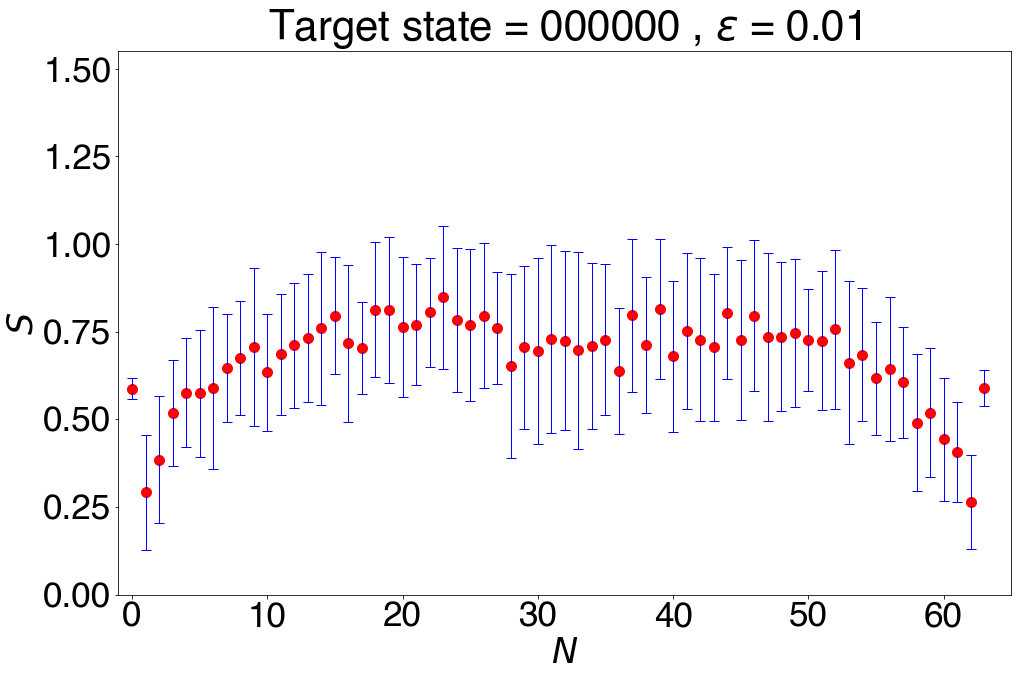

In [238]:
  # Define Data

# Plot error bar

#plt.errorbar(x, y, yerr = np.std(y), fmt = 'o',color = 'red', 
           # ecolor = 'blue', elinewidth = 3, capsize=10)

font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 35}

plt.rc('font', **font)






f = plt.figure()
f.set_figwidth(16)
f.set_figheight(10)    
ind = [i for i in range(2**N)]    
plt.scatter(ind, list(average_s), s = 100, c = 'r')
  
#plt.errorbar(ind, list(average_s), yerr=ind, fmt="o")    
plt.errorbar(ind, average_s.tolist()[0], yerr= Sm_std, fmt="o", color="r",
             ecolor = 'blue', elinewidth = 1, capsize = 5)
plt.title('Target state = ' +str(Target_state) + ' , $\epsilon$ = '+str(eps))
plt.xlabel("$N$")
plt.ylabel("$S$")
plt.xlim(-1,65)
plt.ylim(0,1.55)
plt.savefig('entropy_vs_N.pdf')
plt.show()
# Display graph
